In [1]:
import bz2
import numpy as np
from tqdm import tqdm_notebook as tqdm
import gzip
from heapq import heappushpop
from joblib import Parallel, delayed
import time

In [2]:
data = np.load('CIFAR10_resnet50-keras_features.npz')

In [3]:
x_trn = np.vstack((data['features_training'], data['features_testing']))
y_trn = np.hstack((data['labels_training'], data['labels_testing']))

In [4]:
from sklearn.utils import shuffle
x_trn, y_trn = shuffle(x_trn, y_trn, random_state=0)

In [5]:
x_trn = np.reshape(x_trn, (-1, 2048))
x_tst, y_tst = x_trn[:100], y_trn[:100]
x_val, y_val = x_trn[100:1100], y_trn[100:1100]
x_trn, y_trn = x_trn[1100:], y_trn[1100:]

In [6]:
def get_true_KNN(x_trn,x_tst,K):
    N = x_trn.shape[0]
    N_tst = x_tst.shape[0]
    x_tst_knn_gt = np.zeros((N_tst, N))
    for i_tst in tqdm(range(N_tst)):
        dist_gt = np.zeros(N)
        for i_trn in range(N):
            dist_gt[i_trn] = np.linalg.norm(x_trn[i_trn,:] - x_tst[i_tst, :], 2)
#             if i_trn % 100000 == 0:
#                 print(i_trn)
        x_tst_knn_gt[i_tst, :] = np.argsort(dist_gt)
        # x_sort_part = np.argpartition(dist_gt,K)[:K]
        # x_tst_knn_gt[i_tst, :] = x_sort_part[np.argsort(dist_gt[x_sort_part])]
#         if i_tst % 100 == 0:
#             print(i_tst)

    return x_tst_knn_gt.astype(int)

In [7]:
print(len(x_trn))

58900


In [8]:
start = time.time()
x_tst_knn_gt = get_true_KNN(x_trn, x_tst, 1)
end1 = time.time() - start
print(end1)


45.619296073913574


In [9]:
start = time.time()
x_val_knn_gt = get_true_KNN(x_trn, x_val, 1)
val_end1 = time.time() - start
print(val_end1)


360.9974043369293


In [10]:
def compute_single_unweighted_knn_class_shapley(x_trn,y_trn,x_tst_knn_gt,y_tst,K):
    N = x_trn.shape[0]
    N_tst = x_tst_knn_gt.shape[0]
    sp_gt = np.zeros((N_tst,N))
    for j in tqdm(range(N_tst)):
        # try:
        sp_gt[j,x_tst_knn_gt[j,-1]] = (y_trn[x_tst_knn_gt[j,-1]] == y_tst[j])/N
        # except:
        #     pdb.set_trace()
        for i in np.arange(N-2,-1,-1):
            sp_gt[j,x_tst_knn_gt[j,i]] = sp_gt[j,x_tst_knn_gt[j,i+1]] +\
                           (int(y_trn[x_tst_knn_gt[j,i]] == y_tst[j]) -
                            int(y_trn[x_tst_knn_gt[j,i+1]] == y_tst[j]))/K* min([K,i+1])/(i+1)
            # if j == 404 and i == 0:
            #     pdb.set_trace()
    return sp_gt

In [11]:
start = time.time()
sp_gt = compute_single_unweighted_knn_class_shapley(x_trn, y_trn, x_tst_knn_gt, y_tst, 1)
end2 = time.time() - start

start = time.time()
val_sp_gt = compute_single_unweighted_knn_class_shapley(x_trn, y_trn, x_val_knn_gt, y_val, 1)
val_end2 = time.time() - start

print(end2)
print(val_end2)


32.67850852012634
372.8838129043579


In [12]:
print((end1 + end2) / 100)
print((val_end1 + val_end2) / 1000)

0.7829780459403992
0.7338812172412872


In [13]:
np.save('eps0.1/tst_exact_sp_gt', sp_gt)
np.save('eps0.1/val_exact_sp_gt', val_sp_gt)

In [14]:
def get_contrast(x_trn):
    num_cores = 8
    mc_num = 5
    eps = 0.1
    n_trn = x_trn.shape[0]
    K = int(1 / eps)
    contrast = np.zeros((mc_num))
    dist_rand = np.zeros(mc_num)
    dist_knn = np.zeros((mc_num))

    def compute_distance(i_q, query,x_trn,n_trn,K):
        dist_to_random = np.zeros(n_trn)
        for i_trn in range(n_trn):
            dist_to_random[i_trn] = np.linalg.norm(query - x_trn[i_trn, :], 2)
        dist_to_random_avg = np.mean(dist_to_random)
        dist_to_KNN = np.sort(dist_to_random)[:K]
        # first_K_ind = np.argpartition(dist_to_random, K)[:K]
        # dist_to_KNN= np.sort(dist_to_random[first_K_ind])
        # print(dist_to_random[dist_to_KNN[i_q, :].astype(int)])
        if i_q % 100 == 0:
            print(i_q)
        return dist_to_random_avg,dist_to_KNN

    def estimate_contrast(x_trn,query,K):
        # estimate empirical contrast
        n_trn = x_trn.shape[0]
        n_q = query.shape[0]
        # dist_to_random_avg = np.zeros(n_q)
        # dist_to_KNN = np.zeros((n_q,K))
        from joblib import Parallel, delayed
        result = \
            Parallel(n_jobs=num_cores)(delayed(compute_distance)(i_q,query[i_q,:],x_trn,n_trn,K) for i_q in range(n_q))
        dist_to_random_avg = np.array([result[i][0] for i in range(n_q)])
        dist_to_KKN = np.array([result[i][1] for i in range(n_q)])
        assert dist_to_KKN.shape[0] == n_q
        dist_to_KNN_avg_q = np.mean(dist_to_KKN,axis=0)
        dist_to_random_avg_avg = np.mean(dist_to_random_avg)
        contrast =dist_to_random_avg_avg/dist_to_KNN_avg_q
        return dist_to_random_avg_avg,dist_to_KNN_avg_q,contrast

    contrast = []
    dist_rand = []
    dist_knn = []
    for mc_i in range(mc_num):
        start = time.time()
        sample_ind_trn = np.random.choice(np.arange(n_trn),int(n_trn/5*4),replace=False).astype(int)
        sample_ind_query = np.array(list(set(np.arange(n_trn).astype(int).tolist()) - set(sample_ind_trn.tolist()))).astype(int)
        # if len(sample_ind_query) + len(sample_ind_trn) != n_trn:
        #     print('dimension does not match')
        dist_rand_, dist_knn_, contrast_ = estimate_contrast(x_trn[sample_ind_trn,:],x_trn[sample_ind_query,:],K)
        dist_rand.append(dist_rand_)
        dist_knn.append(dist_knn_)
        contrast.append(contrast_)

        print('monte carlo iteration%s ' % mc_i)
        elapsed_time = time.time() - start
        print('elapsed time is %s' % elapsed_time)
    dist_knn = np.array(dist_knn)
    contrast = np.array(contrast)
    dist_rand = np.array(dist_rand)
    np.save('eps0.1/dist_rand',dist_rand)
    np.save('eps0.1/dist_knn',dist_knn)
    np.save('eps0.1/contrast',contrast)

In [15]:
K = 10
get_contrast(x_val)
dist_rand = np.load('eps0.1/dist_rand.npy')
contrast = np.load('eps0.1/contrast.npy')
dist_knn = np.load('eps0.1/dist_knn.npy')

dist_rand = np.mean(dist_rand, axis=0)
contrast = np.mean(contrast, axis=0)[K-1]
dist_knn = np.mean(dist_knn, axis=0)[K-1]

monte carlo iteration0 
elapsed time is 1.1923508644104004
monte carlo iteration1 
elapsed time is 0.4999969005584717
monte carlo iteration2 
elapsed time is 0.5158400535583496
monte carlo iteration3 
elapsed time is 0.4136996269226074
monte carlo iteration4 
elapsed time is 0.6797780990600586


In [16]:
search_range = np.arange(1e-3, 10, 1e-3)
from scipy.stats import norm


def f_h(x, r):
    y = 1-2*norm.cdf(-r/x) - 2/(np.sqrt(2*np.pi)*r/x)*(1-np.exp(-(r**2/(2*(x**2)))))
    return y

def g_unnormalize(dist_rand,dist_knn,r):
    y = np.log(f_h(dist_knn,r))/np.log(f_h(dist_rand,r))
    return y

def g_normalize(contrast,r):
    y = np.log(f_h(1/contrast,r))/np.log(f_h(1,r))
    return y

def find_best_r_normalize(search_range,contrast):
    y = g_normalize(contrast,search_range)
    min_ind = np.argmin(y)
    return search_range[min_ind]

def find_best_r_unnormalize(search_range,dist_rand,dist_knn):
    y = g_unnormalize(dist_rand,dist_knn,search_range)
    min_ind = np.argmin(y)
    return search_range[min_ind]

r_vec_normalize = find_best_r_normalize(search_range, contrast)
g_vec = g_normalize(contrast, r_vec_normalize)

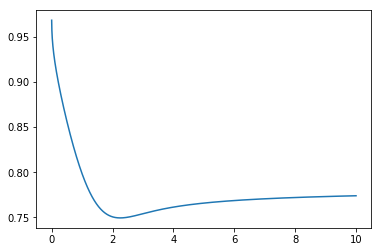

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot g(C_K) vs r, we want g(C_k) to be small
g = g_normalize(contrast,search_range)
plt.figure()
plt.plot(search_range,g)
plt.show()


In [18]:
# search range, find r that minimize g, shape should be 类似 convex

# np.save('data/mnist_mini_selected_param_r_' + str(K) + '.npy', r_vec_normalize)
# np.save('data/mnist_mini_selected_param_g_' + str(K) + '.npy', g_vec)
np.save('eps0.1/selected_param_r_' + str(K) + '.npy', r_vec_normalize)
np.save('eps0.1/selected_param_g_' + str(K) + '.npy', g_vec)

In [19]:
t = r_vec_normalize
n_trn = len(x_trn)
n_hash_table = 10 # 如果 estimation error 高于 0.01
n_hash_bit = int(np.ceil(np.log(n_trn)*0.5/ np.log(1 / f_h(1, t))))
print(n_hash_bit)

13


In [20]:
import numpy as np
import pdb


def lsh_function(t,x,w,b):
    # x is 1-d array
    h = np.floor((np.dot(w,x)+b)/t).astype(int)
    return h


class LSH:
    def __init__(self,n_hash_bit,n_hash_table,x_trn,y_trn,t=0.1):
        self.n_hash_bit = n_hash_bit
        self.n_hash_table = n_hash_table
        self.t = t # width of projections
        self.x_trn = x_trn
        self.y_trn = y_trn
        self.N, self.dim = x_trn.shape
        # draw w from a normal distribution (2-stable)
        self.w = np.random.normal(0, 1, (n_hash_table, n_hash_bit, self.dim))
        # draw b from U[0,t]
        self.b = np.random.uniform(0, self.t, (n_hash_table, n_hash_bit))
        self.x_trn_hash = [dict() for i in range(n_hash_table)]
        for i in tqdm(range(self.N)):
            hash_code_all = lsh_function(self.t, x_trn[i] / dist_rand, self.w, self.b)
            for l in range(n_hash_table):
                hash_code_trn = '.'.join(map(str, hash_code_all[l, :]))
                if hash_code_trn in self.x_trn_hash[l].keys():
                    self.x_trn_hash[l][hash_code_trn].append(i)
                else:
                    self.x_trn_hash[l][hash_code_trn] = [i]
#             if i % 1000 == 0:
#                 print('build hash %s'%i)

    def get_approx_KNN(self,x_tst,K):
        N_tst = x_tst.shape[0]
        x_tst_knn = np.ones((N_tst, K)) * (-1)
        nns_len = np.zeros(N_tst)
        for i_tst in tqdm(range(N_tst)):
            nns = []
            for l in range(self.n_hash_table):
                hash_code_int = lsh_function(self.t, x_tst[i_tst] / dist_rand, self.w[l, :, :], self.b[l, :])
                hash_code_test = '.'.join(map(str, hash_code_int))
                if hash_code_test in self.x_trn_hash[l].keys():
                    nns += self.x_trn_hash[l][hash_code_test]
            nns = np.unique(nns)
            num_collide_elements = len(nns)
            if len(nns) > 0:
                dist = [np.linalg.norm(self.x_trn[i] / dist_rand - x_tst[i_tst] / dist_rand, 2) for i in nns]
                dist_min_ind = nns[np.argsort(dist)]
                if num_collide_elements < K:
                    x_tst_knn[i_tst, :num_collide_elements] = dist_min_ind[:num_collide_elements]
                else:
                    x_tst_knn[i_tst, :] = dist_min_ind[:K]
            # pdb.set_trace()
            nns_len[i_tst] = len(nns)
            if i_tst % 100 == 0:
                print('get approximate knn %s'%i_tst)
        return x_tst_knn.astype(int),nns_len


    def compute_approx_shapley(self,x_tst_knn,y_tst,K):
        N_tst,K_star = x_tst_knn.shape
        # flag_sufficient = (x_tst_knn[:,-1]>=0)
        sp_approx = np.zeros((N_tst,self.N))
        for j in tqdm(range(N_tst)):
            non_nan_index = np.where(x_tst_knn[j,:]>=0)[0]
            if len(non_nan_index)== 0:
                continue
            K_tot = non_nan_index[-1]
            if K_tot == self.N:
                sp_approx[j, x_tst_knn[j, self.N - 1]] = equal(self.y_trn[x_tst_knn[j, self.N - 1]], y_tst[j]) / self.N
            for i in np.arange(K_tot - 1, -1, -1):
                sp_approx[j, x_tst_knn[j, i]] = sp_approx[j, x_tst_knn[j, i+1]] + (
                        equal(self.y_trn[x_tst_knn[j, i]], y_tst[j]) - equal(
                    self.y_trn[x_tst_knn[j, i + 1]], y_tst[j])) / K * min([K, i + 1]) / (i + 1)



        return sp_approx

In [24]:
def equal(a, b):
    return int(a == b)
    
def fine_tune(n_hash_table=10, alpha=0.5, file=False):
    t = r_vec_normalize
    n_trn = len(x_trn)
    n_hash_bit = int(np.ceil(np.log(n_trn)*alpha/ np.log(1 / f_h(1, t))))
    if file is True:
        print(n_hash_bit, file=open('eps0.1/log.txt', 'a'))
    else:
        print(n_hash_bit)
    
    start = time.time()
    lsh = LSH(n_hash_bit=n_hash_bit, n_hash_table=n_hash_table, x_trn=x_trn, y_trn=y_trn, t=t)
    runtime_build_hash = time.time() - start
    if file is True:
        print(runtime_build_hash, file=open('eps0.1/log.txt', 'a'))
    else:
        print(runtime_build_hash)
    
    K_star = 10
    start = time.time()
    x_val_knn_approx, nns_vec = lsh.get_approx_KNN(x_val, K_star)
    runtime_query = time.time() - start
    if file is True:
        print(runtime_query, file=open('eps0.1/log.txt', 'a'))
    else:
        print(runtime_query)
    
    K = 1
    start = time.time()
    sp_approx = lsh.compute_approx_shapley(x_val_knn_approx, y_val, K)
    runtime_approx_value = time.time() - start
    if file is True:
        print('it takes %s to get appox knn value' % runtime_approx_value, file=open('eps0.1/log.txt', 'a'))
    else:
        print('it takes %s to get appox knn value' % runtime_approx_value)
    
    sp_err_inf_val= np.linalg.norm(val_sp_gt - sp_approx,ord=np.inf, axis=1)
    if file is True:
        print('max error %s'% np.percentile(sp_err_inf_val,90), file=open('eps0.1/log.txt', 'a'))
    else:
        print('max error %s'% np.percentile(sp_err_inf_val,90))
    return lsh

In [25]:
def fine_tune_test(n_hash_table=10, lsh=None, file=False):
    if not lsh:
        t = r_vec_normalize
        n_trn = len(x_trn)
        n_hash_bit = int(np.ceil(np.log(n_trn)*0.3/ np.log(1 / f_h(1, t))))
        print(n_hash_bit)
    
        start = time.time()
        lsh = LSH(n_hash_bit=n_hash_bit, n_hash_table=n_hash_table, x_trn=x_trn_norm, y_trn=y_trn, t=t)
        runtime_build_hash = time.time() - start
        print(runtime_build_hash)
    
    K_star = 10
    start = time.time()
    x_tst_knn_approx, nns_vec = lsh.get_approx_KNN(x_tst, K_star)
    runtime_query = time.time() - start
    if file is True:
        print(runtime_query, file=open('eps0.1/log.txt', 'a'))
    else:
        print(runtime_query)
    
    K = 1
    start = time.time()
    sp_approx = lsh.compute_approx_shapley(x_tst_knn_approx, y_tst, K)
    runtime_approx_value = time.time() - start
    if file is True:
        print('it takes %s to get appox knn value' % runtime_approx_value, file=open('eps0.1/log.txt', 'a'))
    else:
        print('it takes %s to get appox knn value' % runtime_approx_value)
    
    sp_err_inf_val= np.linalg.norm(sp_gt - sp_approx,ord=np.inf, axis=1)
    if file is True:
        print('max error %s'% np.percentile(sp_err_inf_val,90), file=open('eps0.1/log.txt', 'a'))
    else:
        print('max error %s'% np.percentile(sp_err_inf_val,90))
    return sp_approx, nns_vec

In [26]:
lsh_10_038 = fine_tune(10, 0.38, file=True)
sp_approx_10_038, nns_vec_10_038 = fine_tune_test(10, lsh_10_038, file=True)

get approximate knn 0
get approximate knn 100
get approximate knn 200
get approximate knn 300
get approximate knn 400
get approximate knn 500
get approximate knn 600
get approximate knn 700
get approximate knn 800
get approximate knn 900



get approximate knn 0



In [27]:
lsh_50_05 = fine_tune(50, 0.5)
sp_approx_50_05, nns_vec_50_05 = fine_tune_test(50, lsh_50_05)

13



45.6403591632843


get approximate knn 0
get approximate knn 100
get approximate knn 200
get approximate knn 300
get approximate knn 400
get approximate knn 500
get approximate knn 600
get approximate knn 700
get approximate knn 800
get approximate knn 900

156.2415816783905



it takes 0.17097902297973633 to get appox knn value
max error 0.20253575444680727


get approximate knn 0

15.579456090927124



it takes 0.027326583862304688 to get appox knn value
max error 0.21762423339177603


In [28]:
lsh_80_053 = fine_tune(80, 0.53, file=True)
sp_approx_80_053, nns_vec_80_053 = fine_tune_test(80, lsh_80_053, file=True)

get approximate knn 0
get approximate knn 100
get approximate knn 200
get approximate knn 300
get approximate knn 400
get approximate knn 500
get approximate knn 600
get approximate knn 700
get approximate knn 800
get approximate knn 900



get approximate knn 0



In [29]:
lsh_70_05 = fine_tune(70, 0.5)
sp_approx_70_05, nns_vec_70_05 = fine_tune_test(70, lsh_70_05)

13



68.34344673156738


get approximate knn 0
get approximate knn 100
get approximate knn 200
get approximate knn 300
get approximate knn 400
get approximate knn 500
get approximate knn 600
get approximate knn 700
get approximate knn 800
get approximate knn 900

237.40560364723206



it takes 0.11438894271850586 to get appox knn value
max error 0.11827851996811087


get approximate knn 0

26.7766854763031



it takes 0.029628276824951172 to get appox knn value
max error 0.2751299183417773


In [30]:
lsh_90_05 = fine_tune(90, 0.5)
sp_approx_90_05, nns_vec_90_05 = fine_tune_test(90, lsh_90_05)

13



85.8965699672699


get approximate knn 0
get approximate knn 100
get approximate knn 200
get approximate knn 300
get approximate knn 400
get approximate knn 500
get approximate knn 600
get approximate knn 700
get approximate knn 800
get approximate knn 900

250.46719098091125



it takes 0.16597199440002441 to get appox knn value
max error 0.09349306089213358


get approximate knn 0

24.273517608642578



it takes 0.029417037963867188 to get appox knn value
max error 0.08004152946165412


In [31]:
lsh_100_053 = fine_tune(100, 0.53)
sp_approx_100_053, nns_vec_100_053 = fine_tune_test(100, lsh_100_053)

14



110.0786452293396


get approximate knn 0
get approximate knn 100
get approximate knn 200
get approximate knn 300
get approximate knn 400
get approximate knn 500
get approximate knn 600
get approximate knn 700
get approximate knn 800
get approximate knn 900

206.68721723556519



it takes 0.11477184295654297 to get appox knn value
max error 0.11582588275601656


get approximate knn 0

22.084858417510986



it takes 0.029247760772705078 to get appox knn value
max error 0.10699171000068633


In [32]:
contrast

1.2802230904946394

In [33]:
lsh_80_05 = fine_tune(80, 0.5)
sp_approx_80_05, nns_vec_80_05 = fine_tune_test(80, lsh_80_05)

13



74.7449734210968


get approximate knn 0
get approximate knn 100
get approximate knn 200
get approximate knn 300
get approximate knn 400
get approximate knn 500
get approximate knn 600
get approximate knn 700
get approximate knn 800
get approximate knn 900

217.46790838241577



it takes 0.15278387069702148 to get appox knn value
max error 0.10094533670762575


get approximate knn 0

20.597107410430908



it takes 0.0592958927154541 to get appox knn value
max error 0.08824139493334386


In [34]:
lsh_110_053 = fine_tune(110, 0.53)
sp_approx_110_053, nns_vec_110_053 = fine_tune_test(110, lsh_110_053)

14



125.68250679969788


get approximate knn 0
get approximate knn 100
get approximate knn 200
get approximate knn 300
get approximate knn 400
get approximate knn 500
get approximate knn 600
get approximate knn 700
get approximate knn 800
get approximate knn 900

235.37226700782776



it takes 0.11734557151794434 to get appox knn value
max error 0.0999173149485893


get approximate knn 0

24.392648935317993



it takes 0.02939438819885254 to get appox knn value
max error 0.11338750311076132


In [35]:
lsh_81_05 = fine_tune(81, 0.5)
sp_approx_81_05, nns_vec_81_05 = fine_tune_test(81, lsh_81_05)

13



79.18347430229187


get approximate knn 0
get approximate knn 100
get approximate knn 200
get approximate knn 300
get approximate knn 400
get approximate knn 500
get approximate knn 600
get approximate knn 700
get approximate knn 800
get approximate knn 900

217.51371431350708



it takes 0.1828761100769043 to get appox knn value
max error 0.12081601593753519


get approximate knn 0

22.435247659683228



it takes 0.029652118682861328 to get appox knn value
max error 0.09808797927637379


In [36]:
lsh_82_05 = fine_tune(82, 0.5)
sp_approx_82_05, nns_vec_82_05 = fine_tune_test(82, lsh_82_05)

13



77.54444336891174


get approximate knn 0
get approximate knn 100
get approximate knn 200
get approximate knn 300
get approximate knn 400
get approximate knn 500
get approximate knn 600
get approximate knn 700
get approximate knn 800
get approximate knn 900

227.003324508667



it takes 0.09798288345336914 to get appox knn value
max error 0.09189972931842029


get approximate knn 0

23.272849798202515



it takes 0.029414653778076172 to get appox knn value
max error 0.08624021721377484


In [37]:
lsh_30_038 = fine_tune(30, 0.38)
sp_approx_30_038, nns_vec_30_038 = fine_tune_test(30, lsh_30_038)

10



22.832886695861816


get approximate knn 0
get approximate knn 100
get approximate knn 200
get approximate knn 300
get approximate knn 400
get approximate knn 500
get approximate knn 600
get approximate knn 700
get approximate knn 800
get approximate knn 900

211.50038647651672



it takes 0.17042779922485352 to get appox knn value
max error 0.1543807731464555


get approximate knn 0

21.10936737060547



it takes 0.05863308906555176 to get appox knn value
max error 0.27628429825992246


In [40]:
np.save('eps0.1/sp_approx_05', sp_approx_82_05)
np.save('eps0.1/lsh_82_05', lsh_82_05)